# Joint data analysis

This will be the notebook in which I will conduct my joint data analysis.
The idea is that I can use my JOD data as well as my quantitative data from the cluster in order to formulate some joint statements about my model performance.

In [112]:
import pandas as pd

df_jod = pd.read_excel("data/jod.xlsx")
df_metrics = pd.read_excel("data/singleMetricResultClean.xlsx")

### Reflection

So given my JOD values, what kind of correlation could I even compute?

For each facet of my data I can create scatterplot where one observation is a method.

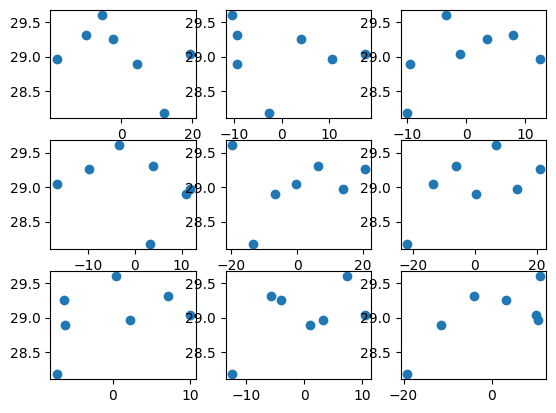

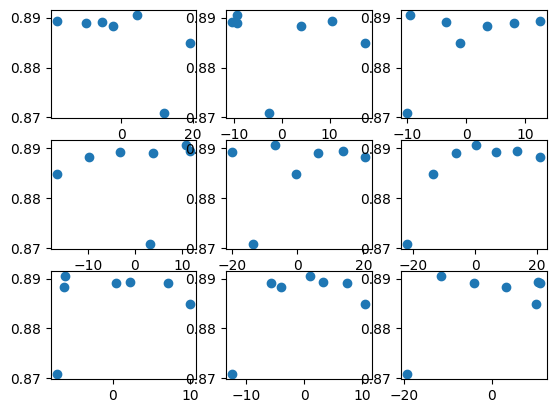

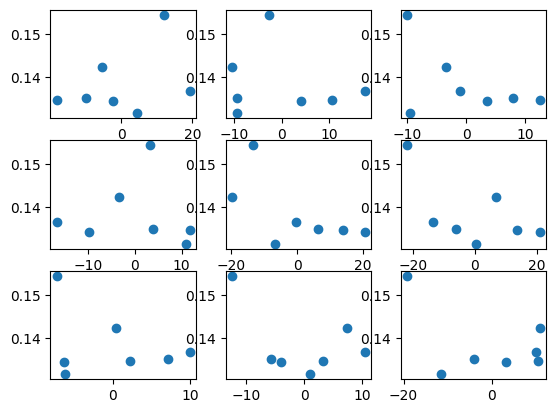

In [113]:
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, norm, spearmanr
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


def compute_linear_rmse(x, y) -> float:
    X = x.values.reshape(-1, 1)  # Reshape for sklearn
    y = y.values

    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)
    rmse_linear = np.sqrt(mean_squared_error(y, y_pred_linear))
    return rmse_linear


def compute_nonlinear_rmse(x, y) -> float:
    X = x.values.reshape(-1, 1)  # Reshape for sklearn
    y = y.values

    # Nonlinear (Quadratic) Regression
    X_nonlinear = np.column_stack((X, X**2))  # Add x^2 term
    nonlinear_model = (
        LinearRegression()
    )  # Still use linear regression, but with transformed features
    nonlinear_model.fit(X_nonlinear, y)
    y_pred_nonlinear = nonlinear_model.predict(X_nonlinear)
    rmse_nonlinear = np.sqrt(mean_squared_error(y, y_pred_nonlinear))
    return rmse_nonlinear


def compute_spearman(x, y) -> float:
    corr, _ = spearmanr(x, y)
    return corr


def compute_pearsonr(x, y) -> float:
    corr, _ = pearsonr(x, y)
    return corr


def plot_quality_metric_against_jod(quality_metric: str = "psnr") -> pd.DataFrame:
    fig, axs = plt.subplots(3, 3)

    records = []

    for i, dataset in enumerate(df_metrics["dataset"].unique()):
        for j, size in enumerate(["low", "medium", "high"]):
            single_facet_df = (
                df_jod[(df_jod["dataset"] == dataset) & (df_jod["size"] == size)]
                .transpose()
                .iloc[3:]
                .rename(lambda x: "jod", axis=1)
            )
            metric_single_facet = (
                df_metrics[
                    (df_metrics["dataset"] == "room") & (df_metrics["size"] == "low")
                ]
                .groupby(["model", "dataset", "size"])[quality_metric]
                .median()
            )
            metrics_df = pd.DataFrame.from_dict(
                {
                    "technique": [
                        technique.replace("-", "_")
                        for technique, _, _ in metric_single_facet.index
                    ],
                    quality_metric: metric_single_facet.values,
                }
            ).set_index("technique")
            single_facet_df = single_facet_df.join(metrics_df)

            axs[i][j].scatter(single_facet_df["jod"], single_facet_df[quality_metric])

            records.append(
                {
                    "dataset": dataset,
                    "size": size,
                    "SROCC": compute_spearman(
                        single_facet_df["jod"], single_facet_df[quality_metric]
                    ),
                    "PLCC": compute_pearsonr(
                        single_facet_df["jod"].astype(np.float32),
                        single_facet_df[quality_metric].astype(np.float32),
                    ),
                    "RMSE_lin": compute_linear_rmse(
                        single_facet_df["jod"],
                        single_facet_df[quality_metric],
                    ),
                    "RMSE_cub": compute_nonlinear_rmse(
                        single_facet_df["jod"],
                        single_facet_df[quality_metric],
                    ),
                }
            )

    plt.show()

    return pd.DataFrame.from_records(records)


df_psnr = plot_quality_metric_against_jod()
df_ssim = plot_quality_metric_against_jod("ssim")
df_lpips = plot_quality_metric_against_jod("lpips")

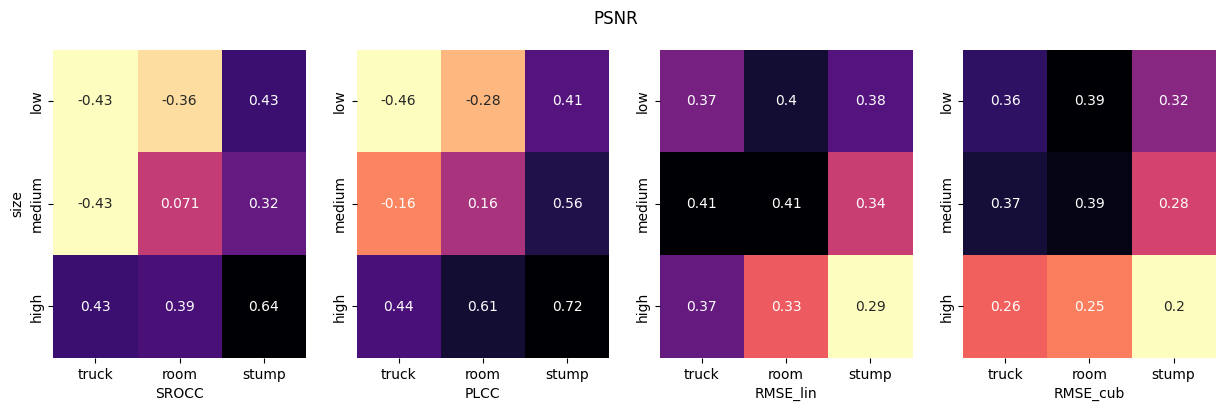

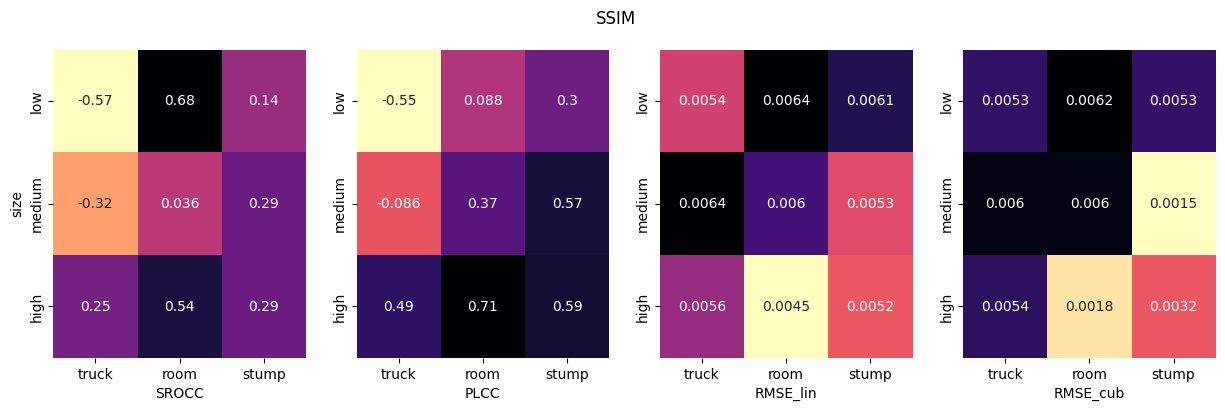

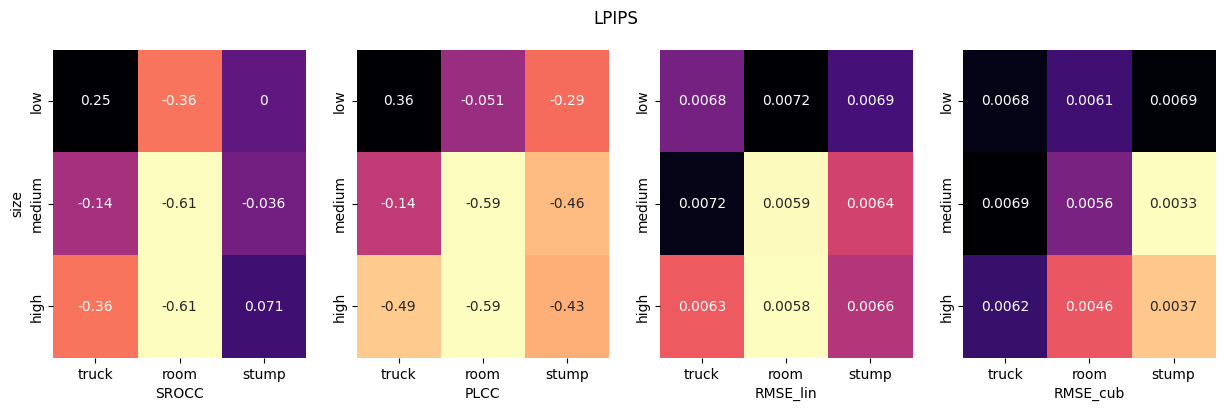

In [119]:
import seaborn as sns


def plot_heatmap_for_metrics(dataframe: pd.DataFrame, title: str):
    metrics = ["SROCC", "PLCC", "RMSE_lin", "RMSE_cub"]

    fig, axs = plt.subplots(1, len(metrics), figsize=(15, 4))

    for i, metric in enumerate(metrics):
        df_pivot = dataframe[[metric, "size", "dataset"]]
        df_pivot = pd.pivot(
            df_pivot, columns=["dataset"], index=["size"], values=[metric]
        )
        df_pivot.columns = df_pivot.columns.map(lambda x: x[1])
        df_pivot.index = pd.CategoricalIndex(
            df_pivot.index, categories=["low", "medium", "high"], ordered=True
        )
        df_pivot.sort_index(inplace=True)
        cmap = sns.color_palette("magma", as_cmap=True).reversed()
        # if "RMSE" in metric:
        #    cmap = cmap.reversed()
        sns.heatmap(
            df_pivot[["truck", "room", "stump"]],
            annot=True,
            ax=axs[i],
            cbar=False,
            cmap=cmap,
        )
        axs[i].set_xlabel(metric)
        if i > 0:
            axs[i].set_ylabel("")

    fig.suptitle(title)
    plt.show()


plot_heatmap_for_metrics(df_psnr, "PSNR")
plot_heatmap_for_metrics(df_ssim, "SSIM")
plot_heatmap_for_metrics(df_lpips, "LPIPS")

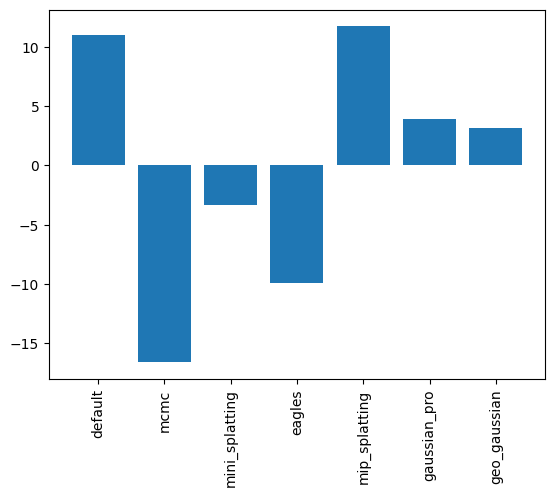

In [120]:
from matplotlib import pyplot as plt

single_facet_df = df_jod[(df_jod["dataset"] == "room") & (df_jod["size"] == "low")].transpose().iloc[3:]

plt.bar(single_facet_df.index, single_facet_df[0])
plt.xticks(rotation=90)
plt.show()


In [116]:
psnr_single_facet = df_metrics[(df_metrics["dataset"] == "room") & (df_metrics["size"] == "low")].groupby(["model", "dataset", "size"])["psnr"].median()

In [117]:
psnr_single_facet

model           dataset  size
default         room     low     28.8986
eagles          room     low     29.2611
gaussian-pro    room     low     29.3104
geo-gaussian    room     low     28.1784
mcmc            room     low     29.0389
mini-splatting  room     low     29.6086
mip-splatting   room     low     28.9718
Name: psnr, dtype: float64

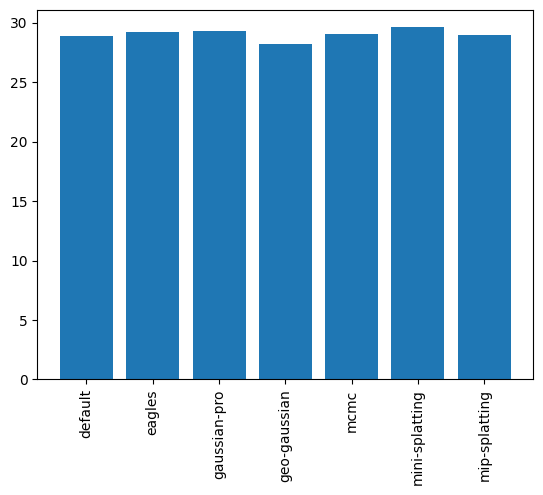

In [118]:
plt.bar([technique for technique, _ , _ in psnr_single_facet.index], psnr_single_facet.values)
plt.xticks(rotation=90)
plt.show()